# Quantum alchemical PES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.offsetbox import AnchoredText

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['font.size'] = 12

from qa_tools.utils import *
from qa_tools.prediction import *
from qa_tools.data import prepare_dfs
from qa_tools.analysis import *

json_path = '../../json-data/atom-pyscf.qa-data.posthf.json'
df_qc, df_qats = prepare_dfs(json_path, get_CBS=False)

## System specifications

Note that the default plot setups will have to change if `n_electrons` is less than 3.

In [2]:
n_electrons = 7
excitation_level = 0
sys_type = 'atom'
basis_set = 'aug-cc-pV5Z'

## Quantum alchemy potential energy surface

Plot is discussed below.

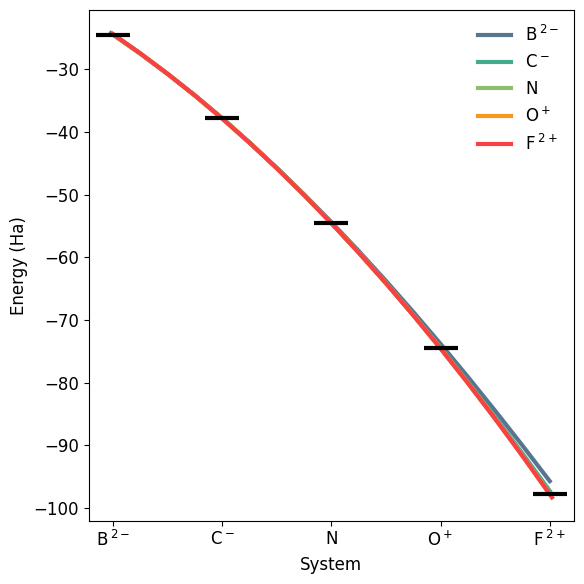

In [3]:
energy_type = 'total'  # total, hf, correlation



###   SCRIPT   ###

# Get system labels and charges for alchemcial PES
df_systems = df_qc.query(
    'n_electrons == @n_electrons'
    '& basis_set == @basis_set'
    '& lambda_value == 0.0'
)
## Selects first (random) multiplicity to get charges.
mult_random = df_systems.iloc[0]['multiplicity']
df_systems = df_systems.query('multiplicity == @mult_random')
## Grabs sorted charges and system labels.
charge_sort = np.argsort(df_systems['charge'].values)
sys_labels = df_systems['system'].values[charge_sort]
sys_charges = df_systems['charge'].values[charge_sort]


# Gets centered lambda values and energies
all_sys_lambda_values = []
all_sys_pes = []
for i in range(len(sys_labels)):
    system_label = sys_labels[i]
    charge = sys_charges[i]
    sys_lambda_values, sys_pes = alchemical_pes(
        df_qc, system_label, charge, excitation_level=excitation_level, basis_set=basis_set,
        bond_length=None, energy_type=energy_type, lambdas_center_neutral=True
    )
    all_sys_lambda_values.append(sys_lambda_values)
    all_sys_pes.append(sys_pes)
all_sys_lambda_values = np.array(all_sys_lambda_values)
all_sys_pes = np.array(all_sys_pes)


# Gets reference quantum chemistry values
qc_energies = np.zeros(len(sys_labels))
for i in range(len(sys_labels)):
    qc_energies[i] = qa_predictions(
        df_qc, sys_labels[i], sys_charges[i], excitation_level=excitation_level, lambda_values=[0],
        basis_set=basis_set, ignore_one_row=True
    )[0]
    
# Prepares system labels
system_labels_condensed = clean_state_labels(sys_labels, sys_charges)


###   FIGURE   ###
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')
line_width = 3

sys_colors = [
    '#577590', '#43AA8B', '#90BE6D', '#F8961E', '#F94144'
]

# Plots alchemical PES
for i in range(len(all_sys_lambda_values)):
    ax.plot(
        all_sys_lambda_values[i], all_sys_pes[i],
        color=sys_colors[i],
        marker='', markersize=0, fillstyle=None,
        linestyle='-', linewidth=line_width,
        label=system_labels_condensed[i], 
        alpha=1
    )
# Plots reference QC values
ax.plot(
    sys_charges, qc_energies,
    marker='_', markersize=25, markeredgewidth=line_width,
    linestyle='',
    color='black'#, zorder=0
)

ax.set_xlabel('System')
ax.set_xticks(sys_charges)
ax.set_xticklabels(system_labels_condensed)

ax.set_ylabel('Energy (Ha)')

ax.legend(frameon=False)

print()

All of the systems in the plot above have the same number of electrons; thus, they are on the same PES.
However, quantum alchemical potential energy surfaces (PESs) are entirely dependent on their reference system.
Each colored line represents a PESs calculated with the specified reference system.
For example, the red line is the quantum alchemical PES computed using nuclear charge perturbations of the 2+ system (for 7 electrons this is O<sup>2+</sup>).
The horizontal black lines are the quantum chemical references; what quantum alchemy is attempting to reproduce.
Deviations from these data represent quantum alchemical error.

### Lollipop energies

Ultimatley we are only interested in the errors for integer lambda values which correspond to specific target systems.
Given the scale of the PES we can use a lollipop chart to demonstrate the quantum alchemical errors for these targets.

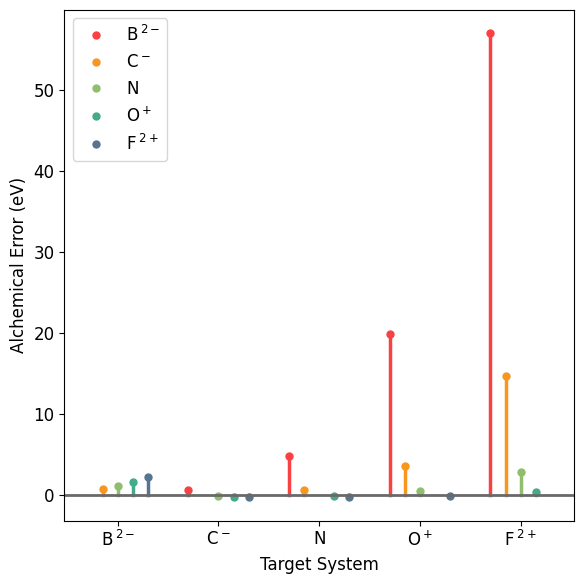

In [4]:
return_energies = False




###   SCRIPT   ###

state_labels, all_energies = qa_pes_errors(
    df_qc, n_electrons, excitation_level=excitation_level,
    basis_set=basis_set, return_energies=return_energies
)

marker_size = 5
line_width = 2.5
j_offset = 0.15


###   FIGURE   ###
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')
sys_colors = [
    '#F94144', '#F8961E', '#90BE6D', '#43AA8B', '#577590'
]

for i in range(len(system_labels_condensed)):
    energies = hartree_to_ev(all_energies[i,:])

    x = [i+j*j_offset for j in range(i+len(energies))]
    for j in range(len(system_labels_condensed)):
        if i == j and i != 0:
            color = 'white'
        else:
            color = sys_colors[j]
        
        ax.plot(
            [x[j], x[j]], [0, energies[j]],
            marker='', markersize=0, 
            linestyle='-', linewidth=line_width,
            color=color
        )
        if i == 0:
            label = system_labels_condensed[j]
            if j == 0:
                ax.plot(
                    x[j], energies[j],
                    marker='o', markersize=marker_size+1, 
                    linestyle='', linewidth=0,
                    color='white', markeredgecolor=None,
                    zorder=2
                )
        else:
            label = None
        
        ax.plot(
            x[j], energies[j],
            marker='o', markersize=marker_size, 
            linestyle='', linewidth=0,
            color=color, markeredgecolor=None,
            label=label, zorder=1
        )


ax.set_xlabel('Target System')
xlabel_offset = ((len(state_labels)-1)/2)*j_offset
xlabel_spacing = [i+xlabel_offset for i in range(len(state_labels))]
ax.set_xticks(xlabel_spacing)
ax.set_xticklabels(system_labels_condensed)

ax.set_ylabel('Alchemical Error (eV)')
ax.axhline(0, color='dimgrey', linewidth=line_width-0.5)

ax.legend()

print()

Each vertical line represents the error using a specific quantum alchemy reference to predict a specific target.

## Predictions with Taylor series

We can then approximate the quantum alchemy PES using a Taylor series.
The following plot shows the overall reproduction of the PES using a specific reference.
`ref_charge` determines which reference state to use for the plot below.

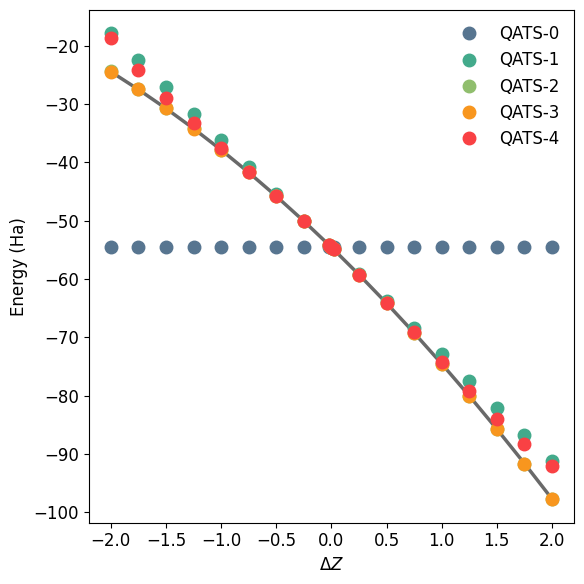

In [5]:
ref_charge = 0  # From -2 to 2 (for most number of electrons)


###   SCRIPT   ###

df_qc_sys = df_qc.query(
    'n_electrons == @n_electrons'
    '& charge == @ref_charge'
    '& basis_set == @basis_set'
)

if len(set(df_qc_sys['multiplicity'].values)) > 1:
    sys_multiplicity = get_multiplicity(df_qc_sys, excitation_level)
    df_qc_sys = df_qc_sys.query('multiplicity == @sys_multiplicity')
else:
    sys_multiplicity = df_qc_sys.iloc[0]['multiplicity']

df_qats_sys = df_qats.query(
    'n_electrons == @n_electrons'
    '& charge == @ref_charge'
    '& basis_set == @basis_set'
    '& multiplicity == @sys_multiplicity'
)
poly_coeffs = df_qats_sys.iloc[0]['poly_coeffs']

lambda_sort = np.argsort(df_qc_sys['lambda_value'].values)

lambda_values = df_qc_sys['lambda_value'].values[lambda_sort]
e_qc = df_qc_sys['electronic_energy'].values[lambda_sort]
e_qats = np.zeros((len(poly_coeffs), len(lambda_values)))

for order in range(len(poly_coeffs)):
    e_qats[order] = np.array(
        [qats_prediction(poly_coeffs, order, l_value)[0] for l_value in lambda_values]
    )

###   FIGURE   ###
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')

order_colors = [
    '#577590', '#43AA8B', '#90BE6D', '#F8961E', '#F94144'
]

# Alchemical PES
ax.plot(
    lambda_values, e_qc,
    color='dimgrey', linewidth=2.5,
    #label='Alchemy'
)

for order in range(len(poly_coeffs)):
    ax.plot(
        lambda_values, e_qats[order],
        color=order_colors[order],
        marker='o', markersize=9, fillstyle='full',
        linestyle='', label=f'QATS-{order}'
    )

ax.set_xlabel('$\Delta Z$')

ax.set_ylabel('Energy (Ha)')

ax.legend(frameon=False)

print()

### Taylor series reference dependence

We can rougly visualize the dependence on quantum alchemy reference for Taylor series.
`ref_charges` specifies which three references you want to look at while `qats_orders` specifies the considered Taylor series order.

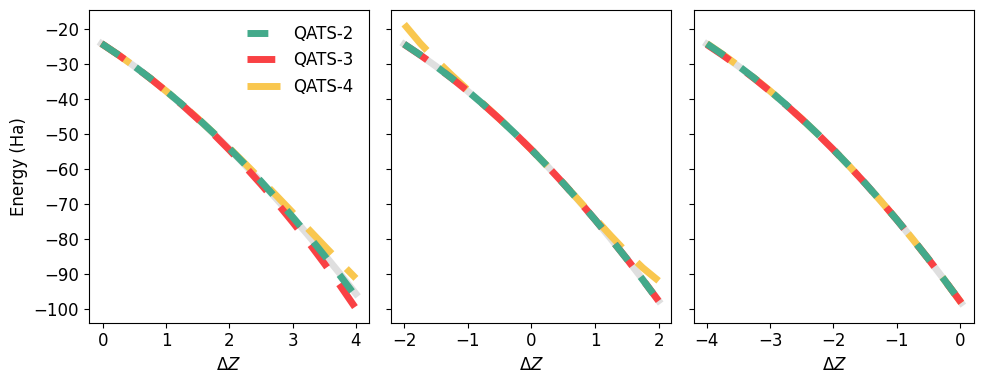

In [6]:
ref_charges = [-2, 0, 2]
qats_orders = [2, 3, 4]


###   SCRIPT   ###

all_energies = []
all_qc_energies = []
all_lambda_values = []

for ref_charge in ref_charges:

    # Neutral charge QA PES
    df_qc_sys = df_qc.query(
        'n_electrons == @n_electrons'
        '& charge == @ref_charge'
        '& basis_set == @basis_set'
    )
    sys_multiplicity = get_multiplicity(df_qc_sys, excitation_level)
    df_qc_sys = df_qc_sys.query('multiplicity == @sys_multiplicity')


    df_qats_sys = df_qats.query(
        'n_electrons == @n_electrons'
        '& charge == @ref_charge'
        '& basis_set == @basis_set'
        '& multiplicity == @sys_multiplicity'
    )
    poly_coeffs = df_qats_sys.iloc[0]['poly_coeffs']

    lambda_sort = np.argsort(df_qc_sys['lambda_value'].values)

    lambda_values = df_qc_sys['lambda_value'].values[lambda_sort]
    e_qc = df_qc_sys['electronic_energy'].values[lambda_sort]
    e_qats = np.zeros((len(qats_orders), len(lambda_values)))

    for j in range(len(qats_orders)):
        order = qats_orders[j]
        e_qats[j] = np.array(
            [qats_prediction(poly_coeffs, order, l_value)[0] for l_value in lambda_values]
        )
    all_qc_energies.append(e_qc)
    all_energies.append(e_qats)
    all_lambda_values.append(lambda_values)

###   FIGURE   ###
fig, axes = plt.subplots(1, 3, tight_layout=True, sharey=True, figsize=(10,4))
fig.patch.set_facecolor('white')
markers = ['o', 'o', 'o', 'o']
order_colors = [
    '#43AA8B', '#F94144', '#F9C74F', '#F8961E', '#F94144'
]
line_width = 5

# Alchemical PES
for i in range(3):
    ax = axes[i]
    lambda_values = all_lambda_values[i]
    e_qc = all_qc_energies[i]
    e_qats = all_energies[i]

    ax.plot(
        lambda_values, e_qc,
        color='silver', linewidth=line_width,
        zorder=0, alpha=0.5
    )

    for j in range(len(qats_orders)):
        qats_order = qats_orders[j]
        """
        ax.plot(
            lambda_values, e_qats[j],
            color=order_colors[j],
            marker=markers[j], markersize=10, fillstyle='none', markeredgewidth=1.25,
            linestyle='', label=f'QATS-{qats_order}',
            zorder=4-j
        )
        """
        ax.plot(
            lambda_values, e_qats[j],
            color=order_colors[j],
            marker='', markersize=0.5, fillstyle='none', markeredgewidth=1.25,
            linestyle=(0, (3+j*1, 3)), linewidth=line_width, label=f'QATS-{qats_order}',
            zorder=4-j
        )

    ax.set_xlabel('$\Delta Z$')

axes[0].set_ylabel('Energy (Ha)')

axes[0].legend(frameon=False)

print()

### Lolliplot for Taylor series errors

Showing the errors with using a Taylor series compared to the quantum chemistry values.

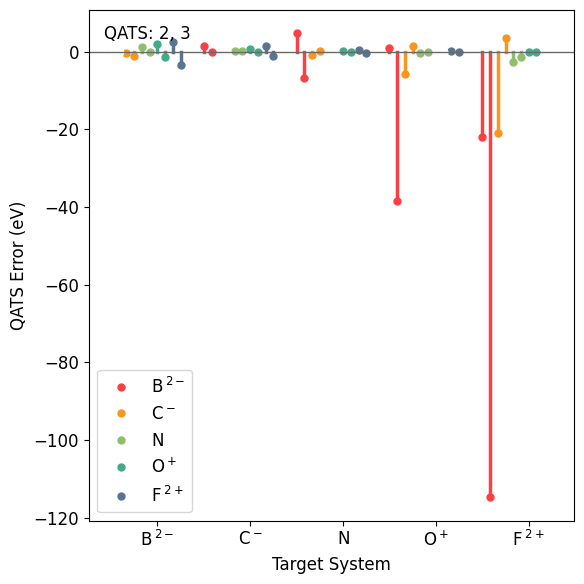

In [7]:
qats_orders = [2, 3]


###   SCRIPT   ###

all_energies = []

for qats_order in qats_orders:
    state_labels, energies = qats_pes_errors(
        df_qc, df_qats, n_electrons, qats_order=qats_order, excitation_level=excitation_level,
        basis_set=basis_set, return_energies=False,
    )
    energies = hartree_to_ev(energies)
    all_energies.append(energies)
all_energies = np.array(all_energies)


marker_size = 5
line_width = 2.5


order_offset = 0.1 + len(qats_orders)*0.2
ref_offset = order_offset*len(qats_orders)
target_offset = ref_offset*(len(state_labels)+1)


###   FIGURE   ###
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')
sys_colors = [
    '#F94144', '#F8961E', '#90BE6D', '#43AA8B', '#577590'
]

for order_i in range(len(qats_orders)):
    if order_i == 0:
        order_offset_plot = 0
    else:
        order_offset_plot = order_offset * order_i
    for i in range(len(system_labels_condensed)):
        energies = all_energies[order_i,i,:]

        x = [i*target_offset+j*ref_offset+order_offset_plot for j in range(i+len(energies))]
        for j in range(len(system_labels_condensed)):
            if i == j and i != 0:
                color = 'white'
            else:
                color = sys_colors[j]

            ax.plot(
                [x[j], x[j]], [0, energies[j]],
                marker='', markersize=0, 
                linestyle='-', linewidth=line_width,
                color=color
            )
            if i == 0:
                label = system_labels_condensed[j]
                if j == 0:
                    ax.plot(
                        x[j], energies[j],
                        marker='o', markersize=marker_size+1, 
                        linestyle='', linewidth=0,
                        color='white', markeredgecolor=None,
                        zorder=2
                    )
            else:
                label = None
            if order_i > 0:
                label = None
                

            ax.plot(
                x[j], energies[j],
                marker='o', markersize=marker_size, 
                linestyle='', linewidth=0,
                color=color, markeredgecolor=None,
                label=label, zorder=1
            )
        

ax.set_xlabel('Target System')
xlabel_spacing = [i*target_offset+(target_offset/2) for i in range(len(state_labels))]
ax.set_xticks(xlabel_spacing)
ax.set_xticklabels(system_labels_condensed)

ax.set_ylabel('QATS Error (eV)')
ax.axhline(0, color='dimgrey', linewidth=1)

anchored_text = AnchoredText(
    f"QATS: " + ', '.join([str(i) for i in qats_orders]),
    loc='upper left', frameon=False
)
ax.add_artist(anchored_text)

ax.legend()

print()

### Heatmaps

Quantum alchemy errors based on reference and target system

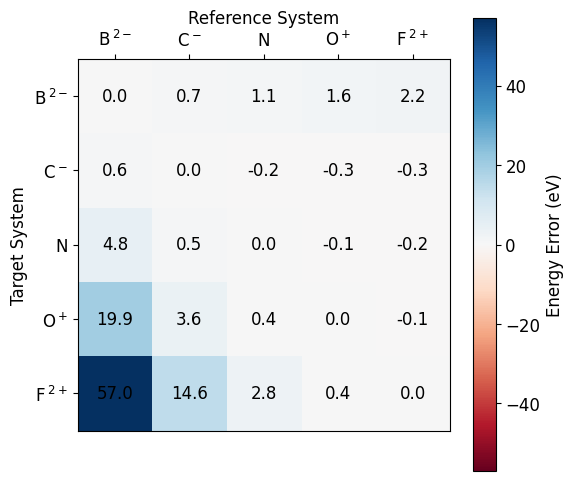

In [8]:
###   SCRIPT   ###

# PES
state_labels, energy_errors = qa_pes_errors(
    df_qc, n_electrons, excitation_level=excitation_level,
    basis_set=basis_set
)


# Prepares system labels
system_labels_condensed = clean_state_labels(sys_labels, sys_charges)
    

# Heatmap with error.
energy_errors = hartree_to_ev(energy_errors)
fig, ax = plt.subplots(1, 1)
fig.patch.set_facecolor('white')
max_abs_error = np.max(np.abs(energy_errors.flatten()))
end_buffer = 0

divnorm=colors.TwoSlopeNorm(
    vmin=-max_abs_error-end_buffer, vcenter=0., vmax=max_abs_error+end_buffer
)
img = ax.imshow(
    energy_errors, cmap='RdBu', norm=divnorm
)

for (j,i),error in np.ndenumerate(energy_errors):
    ax.text(i, j, f'{error:.1f}', ha='center', va='center')

ax.set_xlabel('Reference System')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xticks(range(0, len(system_labels_condensed)))
ax.set_xticklabels(system_labels_condensed)

ax.set_ylabel('Target System')
ax.set_yticks(range(0, len(system_labels_condensed)))
ax.set_yticklabels(system_labels_condensed)

fig.colorbar(img, label='Energy Error (eV)')

print()

## Quantum alchemy errors by contribution

We can dissect the quantum alchemy errors by HF and correlation energy.
`energy_type` specifies which energy component you are interested in.

Energies (eV)
[[-4.05129903 -4.04787205 -4.08275509 -4.07412786 -4.01331974]
 [-3.97586712 -4.22551935 -4.40412726 -4.51086888 -4.57921424]
 [-3.72317987 -4.06635336 -4.30473732 -4.44953739 -4.56202363]
 [-3.45585958 -3.88872878 -4.20346469 -4.3935007  -4.53309852]
 [-3.13031529 -3.65094864 -4.04044322 -4.29004955 -4.46992216]]

 Percent error (Error/Energies)
[[ -0.          -0.0846614    0.77046147   0.56033646  -0.9463311 ]
 [ -6.27918956  -0.           4.05546652   6.32582186   7.72392098]
 [-15.61991296  -5.86235241  -0.           3.25427251   5.63974089]
 [-27.13192209 -12.98038402  -4.52093765  -0.           3.07952305]
 [-42.79463078 -22.43180058 -10.62950054  -4.19278629  -0.        ]]



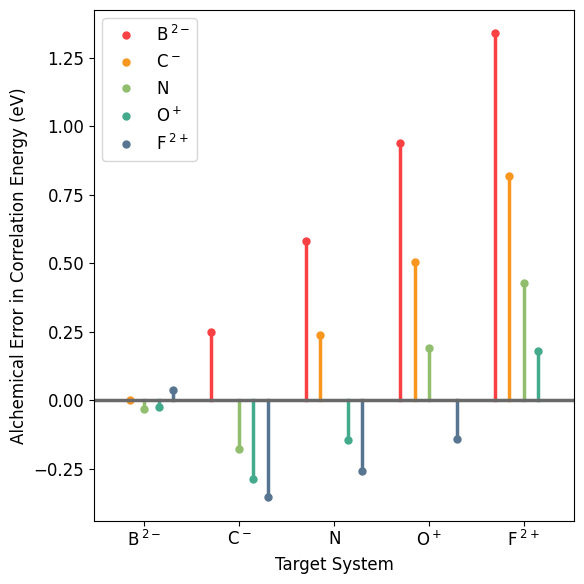

In [9]:
energy_type = 'correlation'  # total, hf, correlation




###   SCRIPT   ###
return_energies = False

state_labels, all_energies = qa_pes_errors(
    df_qc, n_electrons, excitation_level=excitation_level,
    basis_set=basis_set, return_energies=False,
    energy_type=energy_type
)

_, all_energies_test = qa_pes_errors(
    df_qc, n_electrons, excitation_level=excitation_level,
    basis_set=basis_set, return_energies=True,
    energy_type=energy_type
)
print('Energies (eV)')
print(hartree_to_ev(all_energies_test))
print('\n Percent error (Error/Energies)')
print(hartree_to_ev(all_energies)/hartree_to_ev(all_energies_test)*100)





###   FIGURE   ###
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')
sys_colors = [
    '#F94144', '#F8961E', '#90BE6D', '#43AA8B', '#577590'
]

marker_size = 5
line_width = 2.5
j_offset = 0.15

for i in range(len(system_labels_condensed)):
    energies = hartree_to_ev(all_energies[i,:])

    x = [i+j*j_offset for j in range(i+len(energies))]
    for j in range(len(system_labels_condensed)):
        if i == j and i != 0:
            color = 'white'
        else:
            color = sys_colors[j]
        
        ax.plot(
            [x[j], x[j]], [0, energies[j]],
            marker='', markersize=0, 
            linestyle='-', linewidth=line_width,
            color=color
        )
        if i == 0:
            ax.plot(
                x[j], energies[j],
                marker='o', markersize=marker_size, 
                linestyle='', linewidth=0,
                color=color, label=system_labels_condensed[j]
            )
            if j == 0:
                ax.plot(
                x[j], energies[j],
                marker='o', markersize=marker_size+2, 
                linestyle='', linewidth=0,
                color='white', markeredgecolor='white',
            )
        else:
            ax.plot(
                x[j], energies[j],
                marker='o', markersize=marker_size, 
                linestyle='', linewidth=0,
                color=color
            )


ax.set_xlabel('Target System')
xlabel_offset = ((len(state_labels)-1)/2)*j_offset
xlabel_spacing = [i+xlabel_offset for i in range(len(state_labels))]
ax.set_xticks(xlabel_spacing)
ax.set_xticklabels(system_labels_condensed)

y_label = 'Alchemical Error'
if energy_type != 'total':
    if energy_type == 'hf': energy_type = 'HF'
    elif energy_type == 'correlation': energy_type = energy_type.capitalize()
    y_label += f' in {energy_type} Energy'
y_label += ' (eV)'
ax.set_ylabel(y_label)
ax.axhline(0, color='dimgrey', linewidth=line_width)

ax.legend()

print()